<a href="https://colab.research.google.com/github/xy2119/SO3_Equivariant_ProteinMPNN/blob/main/notebooks/demo_CA_SH_wAF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SH-ProteinMPNN w/AF2
This notebook is intended as a quick demo, more features to come!

Examples: 


0.   pdb: `1O91`, homomer: `True`, designed_chain: `A`
1.   pdb: `6MRR`, homomer: `False`, designed_chain: `A`
2.   pdb: `1X2I`, homomer: `True`, designed_chain: `A,B` 
     (for correct symmetric tying lenghts of homomer chains should be the same)

In [1]:
#@title Setup ProteinMPNN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json, time, os, sys, glob, re
from google.colab import files
import numpy as np
if not os.path.isdir("ProteinMPNN"):
  os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")

if "ProteinMPNN" not in sys.path:
  sys.path.append('/content/ProteinMPNN')


In [4]:

import matplotlib.pyplot as plt
import shutil
import warnings
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN, SH_ProteinMPNN

device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "epoch80_CA_SH_48_020" #@param ["v_48_002", "v_48_010", "v_48_020", "v_48_030","vanilla_CA_48_020","ablation_rbf_48_020","epoch80_CA_48_020","epoch80_CA_SH_48_020"]


backbone_noise=0.00               # Standard deviation of Gaussian noise to add to backbone atoms

path_to_model_weights='/content/ProteinMPNN/ca_model_weights'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = SH_ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'],ca_only=True)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded


In [7]:
#@title #Run ProteinMPNN (CA)
print('model loaded:',model_name)
#@markdown #### Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown #### Design Options
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.2" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]



save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()

    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)
                    print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                sequences.append(seq)
                print(line.rstrip())


all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)

model loaded: vanilla_CA_48_020
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
>1O91, score=1.9488, fixed_chains=[], designed_chains=['A'], model_name=vanilla_CA_48_020
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.2, sample=0, score=0.9131, seq_recovery=0.3664
TKPAAKAYLTTSNPTVGTPLVFDTLEYNEGNEYDTSTGVFTATTAGKYYVEFKLYVYGSNLTVSLMKNDTVVKTASKAASGSTLTSVSGSAELDLEVGDKVYIKIPSSSANGIYASATNKSFFSYKLIKEL
>T=0.2, sample=0, score=0.9101, seq_recovery=0.3588
VEEAAKAYLTTSNPAVGTPIKFDTLEYNVGGSYSTSTGVFTATVAGTYEVSFKLYVYGKDVTAEIMKNDEAVLTVSATATGSTLTSVSGSVTLELEVGDKVYVVIPSSAANGIYASSTTKSYFSYKLLKKE
>T=0.2, sample=0, score=0.8635, seq_recovery=0.3359
SAQSATASLTTSNPTVGTPIKFDTLTENTGGAYNTTTGTFTCTTAGTYTVSFTLNVYGSDLTASIMKNTETVKTVSASASGSSVVSVSGSVTLTLAVGDTVSVVIPSSSANGLYATTTLKSTFSFSQTTTT
>T=0.2, sample=0, score=0.9285, seq_recovery=0.3282
AAQKFKAYLTTSNPTVGTPIKFDTLEYNEGGNFNTTTGVFTATTAGTYRISWKLNVYGKDLKVSIMKNDTV

In [8]:
#@title #Run ProteinMPNN (ablation_CA)
print('model loaded:',model_name)
#@markdown #### Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown #### Design Options
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]



save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()

    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)
                    print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                sequences.append(seq)
                print(line.rstrip())


all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)

model loaded: ablation_rbf_48_020
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
tensor([[[1.0000e-03, 3.8141e+00, 6.7805e+00,  ..., 1.3806e+01,
          1.2526e+01, 1.5836e+01],
         [3.8141e+00, 1.0000e-03, 3.8466e+00,  ..., 1.0541e+01,
          9.7988e+00, 1.3276e+01],
         [6.7805e+00, 3.8466e+00, 1.0000e-03,  ..., 1.0856e+01,
          1.0294e+01, 1.3279e+01],
         ...,
         [1.3806e+01, 1.0541e+01, 1.0856e+01,  ..., 1.0000e-03,
          3.8254e+00, 6.2721e+00],
         [1.2526e+01, 9.7988e+00, 1.0294e+01,  ..., 3.8254e+00,
          1.0000e-03, 3.8151e+00],
         [1.5836e+01, 1.3276e+01, 1.3279e+01,  ..., 6.2721e+00,
          3.8151e+00, 1.0000e-03]]])
tensor([[[1., 1., 1.,  

In [20]:
#@title #Run ProteinMPNN (80 epoch CA)
print('model loaded:',model_name)
#@markdown #### Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown #### Design Options
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.2" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]



save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()

    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)
                    print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                sequences.append(seq)
                print(line.rstrip())


all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)

model loaded: epoch80_vanilla_CA_48_020
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
>1O91, score=1.8713, fixed_chains=[], designed_chains=['A'], model_name=epoch80_vanilla_CA_48_020
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.2, sample=0, score=1.0244, seq_recovery=0.4198
GSPSFKAYLTTSYPTVGTPIKFDKVEFNSAGVYDTATGTFTATVPGTYEVSWKVNVKGSDASVQLMKNSTAVKTVSKKAVGGQLTTVSGSATLELKVGDTVYLVVPSSSASGIYASADNPSYFSGKLLKPA
>T=0.2, sample=0, score=1.0114, seq_recovery=0.3740
MKPSFKAYLTTSYPTVNKPIPFDKVEQNNAGVYDTKTGVFTATEPGLYRFEWRVNVYGKDAEVVLMKNDTPVKTLRKKAEGDKLTYVEGSVDLELEVGDKVGLIVPSESKSGIYASADNPSYFSGELVKPK
>T=0.2, sample=0, score=1.0378, seq_recovery=0.3511
MKESFTAYLTSSNPTVNTFIPFNTLSVNNNGAFDTSTGKFTAKTPGLYRVSWTFNVYGGNANVVLMKNDEEVKTVSQTATGSSLSTVSGSETLKLKVGDVVGVKIPSSSSSGVYASSNTPSYFSGELLEPE
>T=0.2, sample=0, score=1.0352, seq_recovery=0.3740
AAPAGTAYLTTSYPTVNKPIVFDQVETNTAGVFDTATGEFTATTPGTYSFTATVY

In [5]:
#@title #Run ProteinMPNN (80 epoch CA_SH)
print('model loaded:',model_name)
#@markdown #### Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown #### Design Options
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.
sampling_temp = "0.2" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]



save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()

    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)
                    print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,b_ix,score_print,seq_rec_print,seq)
                sequences.append(seq)
                print(line.rstrip())


all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)

model loaded: epoch80_CA_SH_48_020
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
E_positional, RBF_all, SH_neighbors shape: torch.Size([1, 131, 48, 16]) torch.Size([1, 131, 48, 144]) torch.Size([1, 131, 48, 3])
SH_features: tensor([[[0.0063, 0.0548, 0.3565],
         [0.0063, 0.0529, 0.5763],
         [0.0063, 0.0537, 0.4969],
         [0.0063, 0.0570, 0.0470],
         [0.0063, 0.0502, 0.7709],
         [0.0063, 0.0470, 0.3437],
         [0.0063, 0.0484, 0.2286],
         [0.0063, 0.0536, 0.1358],
         [0.0063, 0.0553, 0.1439],
         [0.0063, 0.0552, 0.1425],
         [0.0063, 0.0560, 0.1488],
         [0.0063, 0.0569, 0.1574],
         [0.0063, 0.0561, 0.1494],
         [0.0063, 0.0570, 0.1582],
         [0.0063, 0.0568, 0.1567],
         [0.0063, 0.0512, 0.1464],
         [0.0063, 0.0480, 0.2515],
         [0.0063, 0.0567, 0.1557],
         [0.0063, 0.0530, 0.1357],
         [0.0063, 0.0561, 0.1501],
         [0.0063, 0.0495, 0.1823],
         [0.0063

# Predict with AlphaFold2 (with single-sequence input)

In [6]:
#@title Setup AlphaFold

# import libraries
from IPython.utils import io
import os,sys,re

if "af_backprop" not in sys.path:
  import tensorflow as tf
  import jax
  import jax.numpy as jnp
  import numpy as np
  import matplotlib
  from matplotlib import animation
  import matplotlib.pyplot as plt
  from IPython.display import HTML
  import tqdm.notebook
  TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

  with io.capture_output() as captured:
    # install ALPHAFOLD
    if not os.path.isdir("af_backprop"):
      %shell git clone https://github.com/sokrypton/af_backprop.git
      %shell pip -q install biopython dm-haiku ml-collections py3Dmol
      %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
    if not os.path.isdir("params"):
      %shell mkdir params
      %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  if not os.path.exists("MMalign"):
    # install MMalign
    os.system("wget -qnc https://zhanggroup.org/MM-align/bin/module/MMalign.cpp")
    os.system("g++ -static -O3 -ffast-math -o MMalign MMalign.cpp")

  def mmalign(pdb_a,pdb_b):
    # pass to MMalign
    output = os.popen(f'./MMalign {pdb_a} {pdb_b}')
    # parse outputs
    parse_float = lambda x: float(x.split("=")[1].split()[0])
    tms = []
    for line in output:
      line = line.rstrip()
      if line.startswith("TM-score"): tms.append(parse_float(line))
    return tms

  # configure which device to use
  try:
    # check if TPU is available
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print('Running on TPU')
    DEVICE = "tpu"
  except:
    if jax.local_devices()[0].platform == 'cpu':
      print("WARNING: no GPU detected, will be using CPU")
      DEVICE = "cpu"
    else:
      print('Running on GPU')
      DEVICE = "gpu"
      # disable GPU on tensorflow
      tf.config.set_visible_devices([], 'GPU')

  # import libraries
  sys.path.append('af_backprop')
  from utils import update_seq, update_aatype, get_plddt, get_pae
  import colabfold as cf
  from alphafold.common import protein as alphafold_protein
  from alphafold.data import pipeline
  from alphafold.model import data, config
  from alphafold.common import residue_constants
  from alphafold.model import model as alphafold_model

# custom functions
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def setup_model(max_len):
  clear_mem()

  # setup model
  cfg = config.model_config("model_3_ptm")
  cfg.model.num_recycle = 0
  cfg.data.common.num_recycle = 0
  cfg.data.eval.max_msa_clusters = 1
  cfg.data.common.max_extra_msa = 1
  cfg.data.eval.masked_msa_replace_fraction = 0
  cfg.model.global_config.subbatch_size = None

  # get params
  model_param = data.get_model_haiku_params(model_name="model_3_ptm", data_dir=".")
  model_runner = alphafold_model.RunModel(cfg, model_param, is_training=False, recycle_mode="none")

  model_params = []
  for k in [1,2,3,4,5]:
    if k == 3:
      model_params.append(model_param)
    else:
      params = data.get_model_haiku_params(model_name=f"model_{k}_ptm", data_dir=".")
      model_params.append({k: params[k] for k in model_runner.params.keys()})

  seq = "A" * max_len
  length = len(seq)
  feature_dict = {
      **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
      **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
  }
  inputs = model_runner.process_features(feature_dict,random_seed=0)

  def runner(I, params):
    # update sequence
    inputs = I["inputs"]
    inputs.update(I["prev"])

    seq = jax.nn.one_hot(I["seq"],20)
    update_seq(seq, inputs)
    update_aatype(inputs["target_feat"][...,1:], inputs)

    # mask prediction
    mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
    inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
    inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
    inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

    # get prediction
    key = jax.random.PRNGKey(0)
    outputs = model_runner.apply(params, key, inputs)

    prev = {"init_msa_first_row":outputs['representations']['msa_first_row'][None],
            "init_pair":outputs['representations']['pair'][None],
            "init_pos":outputs['structure_module']['final_atom_positions'][None]}
    
    aux = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
           "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
           "plddt":get_plddt(outputs),"pae":get_pae(outputs),
           "length":I["length"], "seq":I["seq"], "prev":prev,
           "residue_idx":inputs["residue_index"][0]}
    return aux

  return jax.jit(runner), model_params, {"inputs":inputs, "length":max_length}

def save_pdb(outs, filename, Ls=None):
  '''save pdb coordinates'''
  p = {"residue_index":outs["residue_idx"] + 1,
       "aatype":outs["seq"],
       "atom_positions":outs["final_atom_positions"],
       "atom_mask":outs["final_atom_mask"],
       "plddt":outs["plddt"]}
  p = jax.tree_map(lambda x:x[:outs["length"]], p)
  b_factors = 100 * p.pop("plddt")[:,None] * p["atom_mask"]
  p = alphafold_protein.Protein(**p,b_factors=b_factors)
  pdb_lines = alphafold_protein.to_pdb(p)
  with open(filename, 'w') as f:
    f.write(pdb_lines)
  if Ls is not None:
    pdb_lines = cf.read_pdb_renum(filename, Ls)
    with open(filename, 'w') as f:
      f.write(pdb_lines)

Running on GPU


/usr/local/lib/python3.8/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [8]:
#@title Run AlphaFold (CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: vanilla_CA_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.391	17.0	0.589
1 0	0.438	15.2	0.544
2 0	0.6	11.4	0.689
3 0	0.42	16.7	0.344
4 0	0.693	9.18	0.845
5 0	0.675	9.31	0.845
6 0	0.516	14.3	0.709
7 0	0.654	10.3	0.659


model loaded: vanilla_CA_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

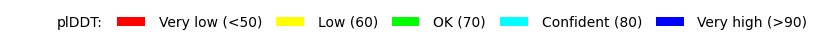

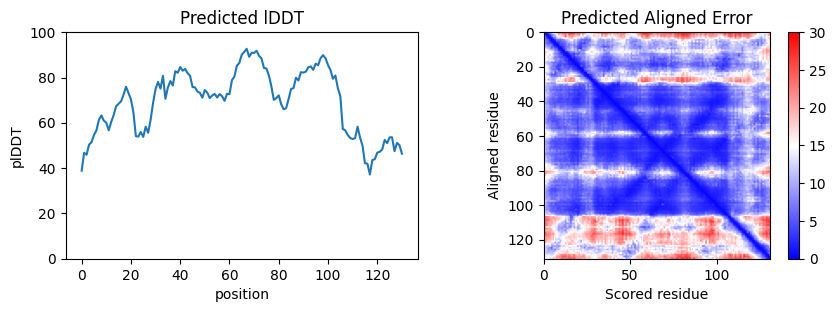

In [18]:
#@title Display 3D structure (CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 4 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [11]:
#@title Run AlphaFold (ablation_rbf_CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: ablation_rbf_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.424	17.5	0.342
1 0	0.475	15.9	0.622
2 0	0.483	14.9	0.699
3 0	0.578	13.1	0.549
4 0	0.46	16.8	0.384
5 0	0.439	16.1	0.661
6 0	0.458	15.7	0.584
7 0	0.322	19.6	0.315


model loaded: ablation_rbf_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

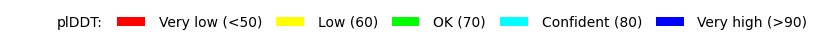

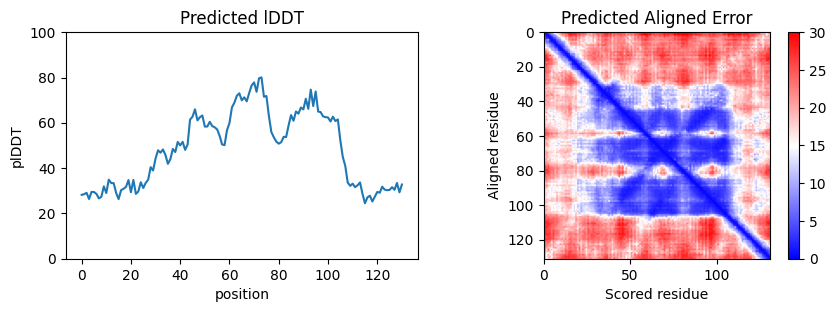

In [13]:
#@title Display 3D structure (ablation_rbf_CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 2 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [21]:
#@title Run AlphaFold (80epoch CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: epoch80_vanilla_CA_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.6	11.5	0.734
1 0	0.334	19.5	0.301
2 0	0.607	12.0	0.68
3 0	0.523	14.4	0.628
4 0	0.395	16.9	0.511
5 0	0.546	13.1	0.529
6 0	0.566	12.7	0.681
7 0	0.559	14.2	0.663


model loaded: epoch80_vanilla_CA_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

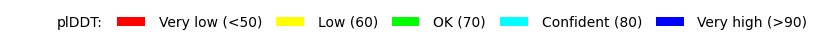

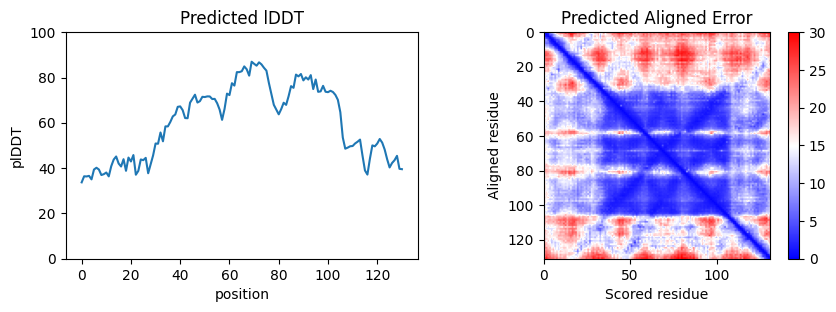

In [22]:
#@title Display 3D structure (80epoch CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 0 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [7]:
#@title Run AlphaFold (80epoch CA_SH)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: epoch80_CA_SH_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.647	11.7	0.769
1 0	0.37	17.7	0.324
2 0	0.535	13.1	0.586
3 0	0.689	9.31	0.851
4 0	0.487	15.0	0.609
5 0	0.333	18.6	0.294
6 0	0.522	13.9	0.782
7 0	0.564	13.0	0.772


model loaded: epoch80_CA_SH_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

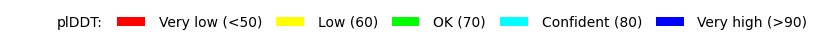

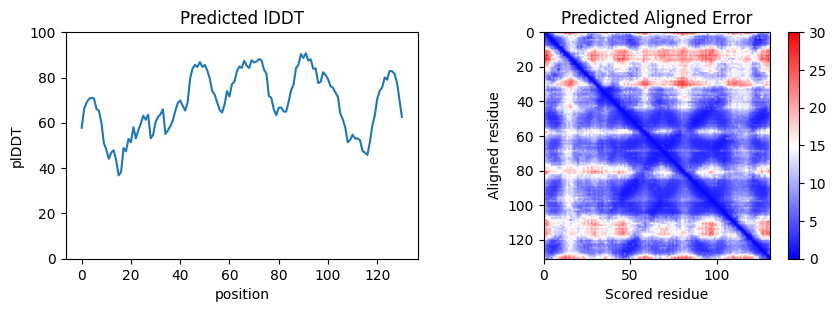

In [8]:
#@title Display 3D structure (80epoch CA_SH) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 3 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

# Save

In [9]:
ls

1O91.pdb      MMalign.cpp            out_seq_4_model_0.pdb  ProteinMPNN/
6MRR.pdb      out_seq_0_model_0.pdb  out_seq_5_model_0.pdb  __pycache__/
af_backprop/  out_seq_1_model_0.pdb  out_seq_6_model_0.pdb  sample_data/
colabfold.py  out_seq_2_model_0.pdb  out_seq_7_model_0.pdb
MMalign*      out_seq_3_model_0.pdb  params/


In [10]:
!zip -r ProteinMPNN.zip ./ProteinMPNN

  adding: ProteinMPNN/ (stored 0%)
  adding: ProteinMPNN/.gitignore (deflated 46%)
  adding: ProteinMPNN/vanilla_model_weights/ (stored 0%)
  adding: ProteinMPNN/vanilla_model_weights/v_48_010.pt (deflated 7%)
  adding: ProteinMPNN/vanilla_model_weights/epoch80_CA_SH_48_020.pt (deflated 11%)
  adding: ProteinMPNN/vanilla_model_weights/v_48_020.pt (deflated 7%)
  adding: ProteinMPNN/vanilla_model_weights/vanilla_CA_48_020.pt (deflated 10%)
  adding: ProteinMPNN/vanilla_model_weights/epoch80_vanilla_CA_48_020.pt (deflated 11%)
  adding: ProteinMPNN/vanilla_model_weights/v_48_030.pt (deflated 7%)
  adding: ProteinMPNN/vanilla_model_weights/v_48_002.pt (deflated 7%)
  adding: ProteinMPNN/vanilla_model_weights/ablation_rbf_48_020.pt (deflated 11%)
  adding: ProteinMPNN/README.md (deflated 66%)
  adding: ProteinMPNN/inputs/ (stored 0%)
  adding: ProteinMPNN/inputs/PDB_homooligomers/ (stored 0%)
  adding: ProteinMPNN/inputs/PDB_homooligomers/pdbs/ (stored 0%)
  adding: ProteinMPNN/inputs/PDB_

In [11]:
files.download('./ProteinMPNN.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>